# A Generative Approach to Modeling Emergent Threats in Multi Agentic Systems

## Pipeline Overview

This notebook implements a **5-stage vulnerability analysis pipeline** for multi-agent systems:

1. **VSG Generation** - 4 specialized agents generate vulnerability stories (Behavioral, Dependency Cascade, Resonant, Temporal)
2. **Deduplication** - Remove duplicate or highly similar vulnerabilities
3. **Plausibility Check** - Score and filter based on technical feasibility
4. **Attack Generation** - SCAMPER framework generates creative exploitation scenarios
5. **Executive Summary** - Business-focused report with prioritized findings and strategic recommendations

The simplified pipeline focuses on generating vulnerability stories, validating them with attack scenarios, and producing actionable executive summaries without intermediate jury evaluation stages.

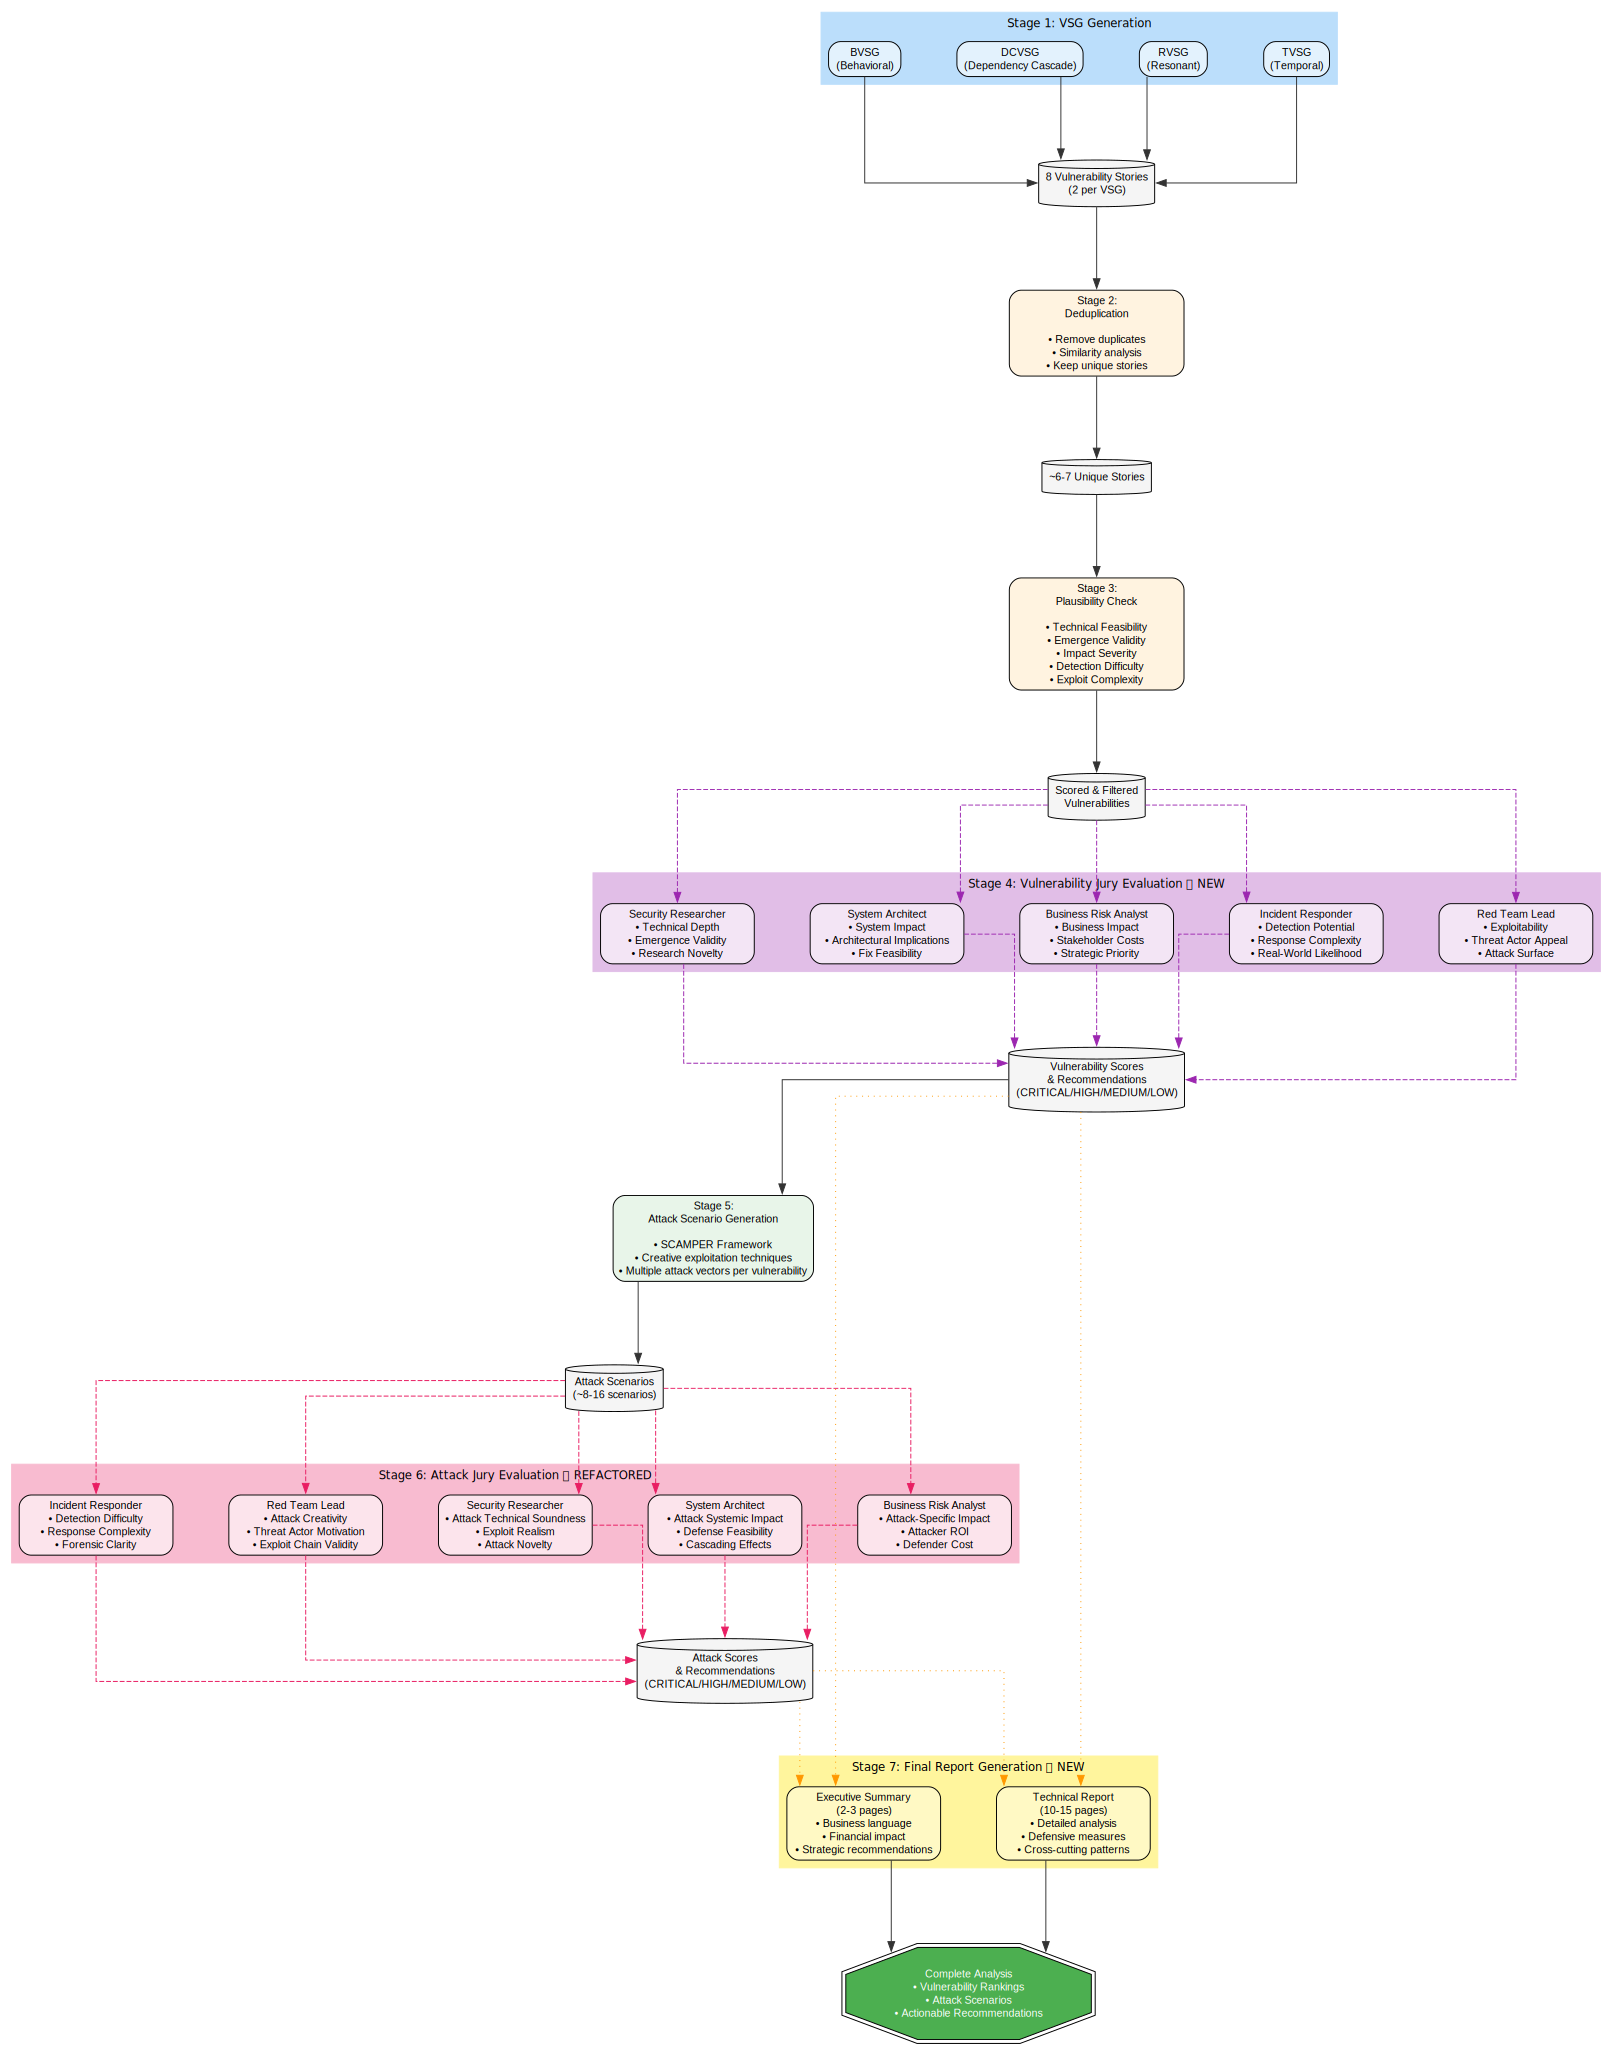

In [21]:
# Generate pipeline visualization
from graphviz import Digraph

# Create diagram
dot = Digraph(comment='TMC 2027 Vulnerability Analysis Pipeline', format='png')
dot.attr(rankdir='TB', splines='ortho', nodesep='0.8', ranksep='1.2')
dot.attr('node', shape='box', style='rounded,filled', fontname='Arial', fontsize='11')
dot.attr('edge', fontname='Arial', fontsize='9', color='#333333')

# Define color scheme
COLOR_VSG = '#E3F2FD'          # Light blue - VSG generation
COLOR_FILTER = '#FFF3E0'       # Light orange - Filtering/processing
COLOR_ATTACK_GEN = '#E8F5E9'   # Light green - Attack generation
COLOR_REPORT = '#FFF9C4'       # Light yellow - Reporting
COLOR_ARTIFACT = '#F5F5F5'     # Light grey - Artifacts

# Stage 1: VSG Generation
with dot.subgraph(name='cluster_stage1') as c:
    c.attr(label='Stage 1: VSG Generation', style='filled', color='#BBDEFB', fontsize='12', fontname='Arial Bold')
    c.node('bvsg', 'BVSG\n(Behavioral)', fillcolor=COLOR_VSG)
    c.node('dcvsg', 'DCVSG\n(Dependency Cascade)', fillcolor=COLOR_VSG)
    c.node('rvsg', 'RVSG\n(Resonant)', fillcolor=COLOR_VSG)
    c.node('tvsg', 'TVSG\n(Temporal)', fillcolor=COLOR_VSG)

dot.node('vsg_output', '8 Vulnerability Stories\n(2 per VSG)', shape='cylinder', fillcolor=COLOR_ARTIFACT)

# Stage 2: Deduplication
dot.node('stage2', 'Stage 2:\nDeduplication\n\n• Remove duplicates\n• Similarity analysis\n• Keep unique stories', fillcolor=COLOR_FILTER, width='2.5')
dot.node('dedup_output', '~6-7 Unique Stories', shape='cylinder', fillcolor=COLOR_ARTIFACT)

# Stage 3: Plausibility Check
dot.node('stage3', 'Stage 3:\nPlausibility Check\n\n• Technical Feasibility\n• Emergence Validity\n• Impact Severity\n• Detection Difficulty\n• Exploit Complexity', fillcolor=COLOR_FILTER, width='2.5')
dot.node('plaus_output', 'Scored & Filtered\nVulnerabilities', shape='cylinder', fillcolor=COLOR_ARTIFACT)

# Stage 4: Attack Generation
dot.node('stage4', 'Stage 4:\nAttack Scenario Generation\n\n• SCAMPER Framework\n• Creative exploitation techniques\n• Multiple attack vectors per vulnerability', fillcolor=COLOR_ATTACK_GEN, width='2.5')
dot.node('attack_output', 'Attack Scenarios\n(~8-16 scenarios)', shape='cylinder', fillcolor=COLOR_ARTIFACT)

# Stage 5: Executive Summary
dot.node('stage5', 'Stage 5:\nExecutive Summary\n\n• Business-focused report\n• Prioritized findings\n• Strategic recommendations\n• Integrates vulnerability + attack insights', fillcolor=COLOR_REPORT, width='2.5')

dot.node('final_output', 'Executive Summary Report\n• Vulnerability Rankings\n• Attack Scenarios Analysis\n• Actionable Recommendations', shape='doubleoctagon', fillcolor='#4CAF50', fontcolor='white', style='filled', width='2.5')

# Edges - Main pipeline flow
dot.edge('bvsg', 'vsg_output')
dot.edge('dcvsg', 'vsg_output')
dot.edge('rvsg', 'vsg_output')
dot.edge('tvsg', 'vsg_output')

dot.edge('vsg_output', 'stage2')
dot.edge('stage2', 'dedup_output')
dot.edge('dedup_output', 'stage3')
dot.edge('stage3', 'plaus_output')

# Stage 4 connections
dot.edge('plaus_output', 'stage4')
dot.edge('stage4', 'attack_output')

# Stage 5 connections
dot.edge('attack_output', 'stage5', label='Attack validation', fontsize='9', color='#4CAF50')
dot.edge('plaus_output', 'stage5', label='Vulnerabilities', fontsize='9', color='#2196F3')
dot.edge('stage5', 'final_output')

# Display inline in notebook
dot


In [10]:
from pathlib import Path
BASE_DIR = Path().resolve()  # current notebook folder
OUT_DIR   = BASE_DIR / "artifacts"
OUT_DIR.mkdir(exist_ok=True)

In [11]:
from dotenv import load_dotenv
import os
load_dotenv(dotenv_path=".env", override=True)
import anthropic

In [12]:
client = anthropic.Anthropic(
    api_key=os.environ.get("ANTHROPIC_API_KEY")
)
message = client.messages.create(
    model="claude-sonnet-4-5",
    max_tokens=1000,
    messages=[
        {
            "role": "user",
            "content": "hello Claude :)"
        }
    ]
)

print(message.content)

[TextBlock(citations=None, text="Hello! :) How are you doing today? Is there anything I can help you with or anything you'd like to chat about?", type='text')]


In [13]:
# run tvsg

import json
from datetime import datetime

# Read the TVSG prompt
with open("prompts/tvsg-prompt.md", "r") as f:
    tvsg_prompt = f.read()

# Read system context (Epic + Protocols)
with open("system/tmc_booking_epic.md", "r") as f:
    epic_content = f.read()

with open("protocols/a2a-threat-model.md", "r") as f:
    a2a_protocol = f.read()

with open("protocols/ans-threat-model.md", "r") as f:
    ans_protocol = f.read()

with open("protocols/ap2-threat-model.md", "r") as f:
    ap2_protocol = f.read()

with open("protocols/mcp_threat_model.md", "r") as f:
    mcp_protocol = f.read()

# Construct the system description for TVSG
system_description = f"""# TMC 2027 Travel Booking Multi-Agent System

## System Epic
{epic_content}

## Protocol Specifications

### A2A Protocol (Agent-to-Agent)
{a2a_protocol}

### ANS Protocol (Agent Name Service)
{ans_protocol}

### AP2 Protocol (Agent Payment Protocol)
{ap2_protocol}

### MCP Protocol (Model Context Protocol)
{mcp_protocol}
"""

# Call Claude with TVSG prompt
print("Generating Temporal Vulnerability Stories...")
print("=" * 80)

response = client.messages.create(
    model="claude-sonnet-4-5-20250929",
    max_tokens=16000,
    temperature=1.0,
    system=tvsg_prompt,
    messages=[
        {
            "role": "user",
            "content": system_description
        }
    ]
)

# Extract the response
tvsg_output = response.content[0].text

print(tvsg_output)
print("\n" + "=" * 80)
print(f"Generated at: {datetime.now().isoformat()}")
print(f"Model: {response.model}")
print(f"Input tokens: {response.usage.input_tokens}")
print(f"Output tokens: {response.usage.output_tokens}")

# Save to artifacts
run_id = "2025-10-19-test-run"  # Change this for different runs
output_dir = f"artifacts/runs/{run_id}/01-vsg-outputs"

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save markdown version
with open(f"{output_dir}/temporal-stories.md", "w") as f:
    f.write(f"# Temporal Vulnerability Stories\n\n")
    f.write(f"**Generated:** {datetime.now().isoformat()}\n")
    f.write(f"**Model:** {response.model}\n")
    f.write(f"**VSG Type:** TVSG (Temporal Vulnerabilities Stories Generator)\n\n")
    f.write("---\n\n")
    f.write(tvsg_output)

print(f"\n✅ Saved to: {output_dir}/temporal-stories.md")


Generating Temporal Vulnerability Stories...
# Temporal Vulnerability Stories: TMC 2027 Travel Booking System

## Vulnerability 1: The Calendar Cascade - When Event Timing Outpaces Coordination Recovery

**Title**: Asynchronous Monitoring Notification Storm During Flight Status Changes

**Temporal Pattern Type**: `timing_cascade`

**Temporal Mechanism**: The TravelMonitoringAgent subscribes to multiple asynchronous event sources (FlightStatusAgent, WeatherAgent, EventUpdateAgent) operating on vastly different update frequencies. Flight status updates arrive every 30-60 seconds during active flight operations, weather updates every 5 minutes, and conference schedule changes sporadically. When a flight delay triggers cascading updates across all monitoring agents simultaneously, the PersonalAssistantAgent receives notification bursts faster than it can process context switches and generate coherent user notifications. The agent's LLM-based decision loop operates on 2-5 second cycles for 

In [14]:
# run bvsg

import json
from datetime import datetime

# Read the BVSG prompt
with open("prompts/bvsg-prompt.md", "r") as f:
    bvsg_prompt = f.read()

# Read system context (Epic + Protocols) - reuse same system description
with open("system/tmc_booking_epic.md", "r") as f:
    epic_content = f.read()

with open("protocols/a2a-threat-model.md", "r") as f:
    a2a_protocol = f.read()

with open("protocols/ans-threat-model.md", "r") as f:
    ans_protocol = f.read()

with open("protocols/ap2-threat-model.md", "r") as f:
    ap2_protocol = f.read()

with open("protocols/mcp_threat_model.md", "r") as f:
    mcp_protocol = f.read()

# Construct the system description for BVSG
system_description = f"""# TMC 2027 Travel Booking Multi-Agent System

## System Epic
{epic_content}

## Protocol Specifications

### A2A Protocol (Agent-to-Agent)
{a2a_protocol}

### ANS Protocol (Agent Name Service)
{ans_protocol}

### AP2 Protocol (Agent Payment Protocol)
{ap2_protocol}

### MCP Protocol (Model Context Protocol)
{mcp_protocol}
"""

# Call Claude with BVSG prompt
print("Generating Behavioral Vulnerability Stories...")
print("=" * 80)

response = client.messages.create(
    model="claude-sonnet-4-5-20250929",
    max_tokens=6000,
    temperature=1.0,
    system=bvsg_prompt,
    messages=[
        {
            "role": "user",
            "content": system_description
        }
    ]
)

# Extract the response
bvsg_output = response.content[0].text

print(bvsg_output)
print("\n" + "=" * 80)
print(f"Generated at: {datetime.now().isoformat()}")
print(f"Model: {response.model}")
print(f"Input tokens: {response.usage.input_tokens}")
print(f"Output tokens: {response.usage.output_tokens}")

# Save to artifacts
run_id = "2025-10-19-test-run"  # Change this for different runs
output_dir = f"artifacts/runs/{run_id}/01-vsg-outputs"

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save markdown version
with open(f"{output_dir}/behavioral-stories.md", "w") as f:
    f.write(f"# Behavioral Vulnerability Stories\n\n")
    f.write(f"**Generated:** {datetime.now().isoformat()}\n")
    f.write(f"**Model:** {response.model}\n")
    f.write(f"**VSG Type:** BVSG (Behavioral Vulnerabilities Stories Generator)\n\n")
    f.write("---\n\n")
    f.write(bvsg_output)

print(f"\n✅ Saved to: {output_dir}/behavioral-stories.md")


Generating Behavioral Vulnerability Stories...
# Behavioral Vulnerabilities: TMC 2027 Travel Booking System

## Vulnerability 1: Payment Processor Arms Race Cascade

**Title**: Multi-Agent Payment Processor Competition Triggers Systemic Fee Inflation

**Behavioral Pattern Type**: `adversarial`

**Behavioral Mechanism**: The PaymentCoordinatorAgent, FlightBookingAgent, HotelReservationAgent, and EventRegistrationAgent each independently select payment processors to minimize transaction costs and maximize reliability. However, payment processors (StripePaymentAgent and competing services) implement dynamic pricing algorithms that increase fees during high-demand periods. When multiple booking agents simultaneously compete for the lowest-cost processor, they trigger adversarial bidding dynamics where processors recognize coordinated demand patterns and collectively raise fees. Each agent rationally switches processors to find better rates, but this switching behavior signals price elastic

In [15]:
# run rvsg

import json
from datetime import datetime

# Read the RVSG prompt
with open("prompts/rvsg-prompt.md", "r") as f:
    rvsg_prompt = f.read()

# Read system context (Epic + Protocols)
with open("system/tmc_booking_epic.md", "r") as f:
    epic_content = f.read()

with open("protocols/a2a-threat-model.md", "r") as f:
    a2a_protocol = f.read()

with open("protocols/ans-threat-model.md", "r") as f:
    ans_protocol = f.read()

with open("protocols/ap2-threat-model.md", "r") as f:
    ap2_protocol = f.read()

with open("protocols/mcp_threat_model.md", "r") as f:
    mcp_protocol = f.read()

# Construct the system description for RVSG
system_description = f"""# TMC 2027 Travel Booking Multi-Agent System

## System Epic
{epic_content}

## Protocol Specifications

### A2A Protocol (Agent-to-Agent)
{a2a_protocol}

### ANS Protocol (Agent Name Service)
{ans_protocol}

### AP2 Protocol (Agent Payment Protocol)
{ap2_protocol}

### MCP Protocol (Model Context Protocol)
{mcp_protocol}
"""

# Call Claude with RVSG prompt
print("Generating Resonant Vulnerability Stories...")
print("=" * 80)

response = client.messages.create(
    model="claude-sonnet-4-5-20250929",
    max_tokens=6000,
    temperature=1.0,
    system=rvsg_prompt,
    messages=[
        {
            "role": "user",
            "content": system_description
        }
    ]
)

# Extract the response
rvsg_output = response.content[0].text

print(rvsg_output)
print("\n" + "=" * 80)
print(f"Generated at: {datetime.now().isoformat()}")
print(f"Model: {response.model}")
print(f"Input tokens: {response.usage.input_tokens}")
print(f"Output tokens: {response.usage.output_tokens}")

# Save to artifacts
run_id = "2025-10-19-test-run"  # Change this for different runs
output_dir = f"artifacts/runs/{run_id}/01-vsg-outputs"

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save markdown version
with open(f"{output_dir}/resonant-stories.md", "w") as f:
    f.write(f"# Resonant Vulnerability Stories\n\n")
    f.write(f"**Generated:** {datetime.now().isoformat()}\n")
    f.write(f"**Model:** {response.model}\n")
    f.write(f"**VSG Type:** RVSG (Resonant Vulnerabilities Stories Generator)\n\n")
    f.write("---\n\n")
    f.write(rvsg_output)

print(f"\n✅ Saved to: {output_dir}/resonant-stories.md")


Generating Resonant Vulnerability Stories...
# Resonant Vulnerability Stories: TMC 2027 Travel Booking System

## Vulnerability 1: The Midnight Certificate Cascade

**Title**: Synchronized Certificate Expiration Amplification Across Payment Processing Chain

**Pattern Classification**: 
- Primary: `synchronization`
- Secondary: `threshold`

**Amplification Mechanism**: All payment-related MCP servers and OAuth tokens share identical 90-day expiration cycles aligned to calendar quarters (January 1, April 1, July 1, October 1 at 00:00 UTC). When midnight UTC strikes on expiration date, ALL payment authentication simultaneously fails across the entire booking pipeline. Single time boundary crossing → 100% payment system failure. Temporal alignment of certificate/token lifecycles creates synchronized failure window where 1 expired credential becomes 15+ expired credentials instantaneously. Amplification multiplier: 1 expiration event → complete payment infrastructure collapse.

**Narrative

In [16]:
# run dcvsg

import json
from datetime import datetime

# Read the DCVSG prompt
with open("prompts/dcvsg-prompt.md", "r") as f:
    dcvsg_prompt = f.read()

# Read system context (Epic + Protocols)
with open("system/tmc_booking_epic.md", "r") as f:
    epic_content = f.read()

with open("protocols/a2a-threat-model.md", "r") as f:
    a2a_protocol = f.read()

with open("protocols/ans-threat-model.md", "r") as f:
    ans_protocol = f.read()

with open("protocols/ap2-threat-model.md", "r") as f:
    ap2_protocol = f.read()

with open("protocols/mcp_threat_model.md", "r") as f:
    mcp_protocol = f.read()

# Construct the system description for DCVSG
system_description = f"""# TMC 2027 Travel Booking Multi-Agent System

## System Epic
{epic_content}

## Protocol Specifications

### A2A Protocol (Agent-to-Agent)
{a2a_protocol}

### ANS Protocol (Agent Name Service)
{ans_protocol}

### AP2 Protocol (Agent Payment Protocol)
{ap2_protocol}

### MCP Protocol (Model Context Protocol)
{mcp_protocol}
"""

# Call Claude with DCVSG prompt
print("Generating Dependency Cascade Vulnerability Stories...")
print("=" * 80)

response = client.messages.create(
    model="claude-sonnet-4-5-20250929",
    max_tokens=6000,
    temperature=1.0,
    system=dcvsg_prompt,
    messages=[
        {
            "role": "user",
            "content": system_description
        }
    ]
)

# Extract the response
dcvsg_output = response.content[0].text

print(dcvsg_output)
print("\n" + "=" * 80)
print(f"Generated at: {datetime.now().isoformat()}")
print(f"Model: {response.model}")
print(f"Input tokens: {response.usage.input_tokens}")
print(f"Output tokens: {response.usage.output_tokens}")

# Save to artifacts
run_id = "2025-10-19-test-run"  # Change this for different runs
output_dir = f"artifacts/runs/{run_id}/01-vsg-outputs"

# Create directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save markdown version
with open(f"{output_dir}/dependency-stories.md", "w") as f:
    f.write(f"# Dependency Cascade Vulnerability Stories\n\n")
    f.write(f"**Generated:** {datetime.now().isoformat()}\n")
    f.write(f"**Model:** {response.model}\n")
    f.write(f"**VSG Type:** DCVSG (Dependency Cascade Vulnerabilities Stories Generator)\n\n")
    f.write("---\n\n")
    f.write(dcvsg_output)

print(f"\n✅ Saved to: {output_dir}/dependency-stories.md")


Generating Dependency Cascade Vulnerability Stories...
# Dependency Cascade Vulnerability Stories: TMC 2027 Travel Booking System

## Vulnerability 1: OAuth Token Service Collapse Propagates Through Payment Authorization Chain

**Title**: Cascading Payment Authorization Failure from Shared OAuth Infrastructure Compromise

**Cascade Topology**: `hub_spoke` (with sequential propagation characteristics)

**Dependency Chain**: All payment-related agents depend on a centralized OAuth 2.1 token service for authorization. The chain flows: OAuth Token Service → PaymentCoordinatorAgent (for session management) → FlightBookingAgent (for airline payment authorization) → HotelReservationAgent (for hotel payment authorization) → EventRegistrationAgent (for conference payment authorization). Additionally, the MCP OAuth connections from various agents to external APIs (airline, hotel, event registration systems) all route through this same token service for credential validation. Chain: **OAuth Token

In [17]:
# run deduplicator

import json
from datetime import datetime

# Read the deduplicator prompt
with open("prompts/deduplicator-prompt.md", "r") as f:
    dedup_prompt = f.read()

# Set run ID
run_id = "2025-10-19-test-run"
input_dir = f"artifacts/runs/{run_id}/01-vsg-outputs"

# Read all 4 story files
with open(f"{input_dir}/behavioral-stories.md", "r") as f:
    behavioral_stories = f.read()

with open(f"{input_dir}/dependency-stories.md", "r") as f:
    dependency_stories = f.read()

with open(f"{input_dir}/resonant-stories.md", "r") as f:
    resonant_stories = f.read()

with open(f"{input_dir}/temporal-stories.md", "r") as f:
    temporal_stories = f.read()

# Combine all stories for deduplication analysis
all_stories = f"""# All Generated Vulnerability Stories (8 total)

## Behavioral Vulnerability Stories (BVSG)
{behavioral_stories}

---

## Dependency Cascade Vulnerability Stories (DCVSG)
{dependency_stories}

---

## Resonant Vulnerability Stories (RVSG)
{resonant_stories}

---

## Temporal Vulnerability Stories (TVSG)
{temporal_stories}
"""

# Call Claude with deduplicator prompt
print("Running Deduplication Analysis...")
print("=" * 80)

response = client.messages.create(
    model="claude-sonnet-4-5-20250929",
    max_tokens=8000,
    temperature=0.3,  # Lower temperature for analytical consistency
    system=dedup_prompt,
    messages=[
        {
            "role": "user",
            "content": all_stories
        }
    ]
)

# Extract the response
dedup_output = response.content[0].text

print(dedup_output)
print("\n" + "=" * 80)
print(f"Generated at: {datetime.now().isoformat()}")
print(f"Model: {response.model}")
print(f"Input tokens: {response.usage.input_tokens}")
print(f"Output tokens: {response.usage.output_tokens}")

# Save to artifacts
output_dir = f"artifacts/runs/{run_id}/02-deduplicated"
os.makedirs(output_dir, exist_ok=True)

# Save deduplication report
with open(f"{output_dir}/deduplication-report.md", "w") as f:
    f.write(f"# Deduplication Report\n\n")
    f.write(f"**Generated:** {datetime.now().isoformat()}\n")
    f.write(f"**Model:** {response.model}\n")
    f.write(f"**Input Stories:** 8 (2 from each VSG)\n\n")
    f.write("---\n\n")
    f.write(dedup_output)

print(f"\n✅ Saved to: {output_dir}/deduplication-report.md")


Running Deduplication Analysis...
# Vulnerability Story Deduplication Analysis

## Summary Statistics
- Total stories analyzed: 8
- Unique stories: 6
- Duplicate groups found: 1
- Stories removed as duplicates: 2

---

## Duplicate Groups

### Duplicate Group 1: OAuth/Certificate Expiration Causing Payment System Failure

**Stories in this group**:
- Story ID 1: DCVSG - "OAuth Token Service Collapse Propagates Through Payment Authorization Chain"
- Story ID 2: RVSG - "The Midnight Certificate Cascade"

**Similarity Analysis**:

**Root cause overlap**: Same - Both describe authentication/authorization credential expiration (OAuth tokens in DCVSG, certificates/tokens in RVSG) causing payment system failures

**Agent overlap**: High overlap
- Shared agents: PaymentCoordinatorAgent, FlightBookingAgent, HotelReservationAgent, EventRegistrationAgent, OAuth/authentication infrastructure
- DCVSG focuses on OAuth Token Service as hub
- RVSG focuses on synchronized certificate expiration across 

In [18]:
# run plausibility checker

import json
from datetime import datetime

# Read the plausibility checker prompt
with open("prompts/plausibility-checker-prompt.md", "r") as f:
    plausibility_prompt = f.read()

# Set run ID
run_id = "2025-10-19-test-run"
input_dir = f"artifacts/runs/{run_id}/01-vsg-outputs"

# Read all 4 story files (containing 8 stories total)
with open(f"{input_dir}/behavioral-stories.md", "r") as f:
    behavioral_stories = f.read()

with open(f"{input_dir}/dependency-stories.md", "r") as f:
    dependency_stories = f.read()

with open(f"{input_dir}/resonant-stories.md", "r") as f:
    resonant_stories = f.read()

with open(f"{input_dir}/temporal-stories.md", "r") as f:
    temporal_stories = f.read()

# Combine all stories for plausibility evaluation
all_stories = f"""# All Generated Vulnerability Stories for Plausibility Assessment

## Behavioral Vulnerability Stories (BVSG)
{behavioral_stories}

---

## Dependency Cascade Vulnerability Stories (DCVSG)
{dependency_stories}

---

## Resonant Vulnerability Stories (RVSG)
{resonant_stories}

---

## Temporal Vulnerability Stories (TVSG)
{temporal_stories}
"""

# Call Claude with plausibility checker prompt
print("Running Plausibility Assessment...")
print("=" * 80)

response = client.messages.create(
    model="claude-sonnet-4-5-20250929",
    max_tokens=12000,  # Larger for detailed scoring of 8 stories
    temperature=0.3,  # Lower temperature for consistent analytical scoring
    system=plausibility_prompt,
    messages=[
        {
            "role": "user",
            "content": all_stories
        }
    ]
)

# Extract the response
plausibility_output = response.content[0].text

print(plausibility_output)
print("\n" + "=" * 80)
print(f"Generated at: {datetime.now().isoformat()}")
print(f"Model: {response.model}")
print(f"Input tokens: {response.usage.input_tokens}")
print(f"Output tokens: {response.usage.output_tokens}")

# Save to artifacts
output_dir = f"artifacts/runs/{run_id}/03-plausibility"
os.makedirs(output_dir, exist_ok=True)

# Save plausibility report
with open(f"{output_dir}/plausibility-scores.md", "w") as f:
    f.write(f"# Plausibility Assessment Report\n\n")
    f.write(f"**Generated:** {datetime.now().isoformat()}\n")
    f.write(f"**Model:** {response.model}\n")
    f.write(f"**Stories Evaluated:** 8\n")
    f.write(f"**Scoring Threshold:** ≥7.0 to KEEP\n\n")
    f.write("---\n\n")
    f.write(plausibility_output)

print(f"\n✅ Saved to: {output_dir}/plausibility-scores.md")


Running Plausibility Assessment...
# Plausibility Assessment Report: TMC 2027 Vulnerability Stories

## Assessment Date
2025-10-19

## Assessor
Vulnerability Story Plausibility Checker Agent

---

# BEHAVIORAL VULNERABILITY STORIES (BVSG)

## Story 1: Payment Processor Arms Race Cascade

### Story Identification
**Story Title**: Multi-Agent Payment Processor Competition Triggers Systemic Fee Inflation
**VSG Type**: BVSG
**Pattern Type**: adversarial

### Dimension Scores

**Technical Feasibility**: 6/10
- Reasoning: The core mechanism of dynamic pricing by payment processors is realistic, and the concept of agents switching processors based on fees is plausible. However, the story assumes payment processors implement sophisticated ML algorithms that detect and respond to agent switching patterns within 48 hours, which is aggressive. The claim that processors "coordinate" through parallel ML discovery of Nash equilibrium without collusion is theoretically possible but practically diffic

In [ ]:
# run attack generator (SCAMPER) - Stage 5

import json
import re
from datetime import datetime
import jsonschema

# Load JSON schema for validation
with open("artifacts/templates/attack-scenario-schema.json", "r") as f:
    attack_schema = json.load(f)

# Read the attack generator prompt
with open("prompts/attack-generator-prompt.md", "r") as f:
    attack_prompt_base = f.read()

# Add JSON output instruction to the prompt
json_output_instruction = """

## CRITICAL OUTPUT FORMAT REQUIREMENT

You MUST output your attack scenarios as a JSON array. Each attack scenario should be a JSON object with this structure:

```json
{
  "attack_title": "Descriptive name for the attack",
  "scamper_dimensions": ["Dimension1", "Dimension2"],
  "attacker_profile": "Type of threat actor",
  "prerequisites": ["prerequisite 1", "prerequisite 2"],
  "attack_narrative": "200-300 word narrative describing how the attack unfolds",
  "attack_steps": ["Step 1", "Step 2", "Step 3"],
  "exploitation_mechanism": "Explanation of how this exploits the vulnerability",
  "attack_impact": {
    "primary_goal": "What attacker achieves",
    "blast_radius": "Scope of damage",
    "duration": "Time to execute and persist"
  },
  "detection_difficulty": "Easy|Moderate|Hard|Very Hard",
  "detection_reasoning": "Why this difficulty level",
  "defensive_mitigations": [
    {"name": "Mitigation 1", "description": "How it works"},
    {"name": "Mitigation 2", "description": "How it works"}
  ]
}
```

Output ONLY the JSON array containing 2-3 attack scenario objects. Do not include markdown formatting, code fences, or explanatory text - just the raw JSON array.
"""

attack_prompt = attack_prompt_base + json_output_instruction

# Set run ID
run_id = "2025-10-19-test-run"
input_dir = f"artifacts/runs/{run_id}/01-vsg-outputs"

# Read all 4 story files
story_files = [
    ("behavioral-stories.md", "BVSG"),
    ("dependency-stories.md", "DCVSG"),
    ("resonant-stories.md", "RVSG"),
    ("temporal-stories.md", "TVSG")
]

# Parse individual stories from each file
def extract_stories(content, vsg_type):
    """Extract individual stories from a VSG output file."""
    pattern = r'(## (?:Vulnerability|Story) \d+:.*?)(?=## (?:Vulnerability|Story) \d+:|$)'
    matches = re.findall(pattern, content, re.DOTALL)

    if not matches:
        return [(f"{vsg_type} - Full Content", content)]

    stories = []
    for i, match in enumerate(matches, 1):
        title_match = re.search(r'## (?:Vulnerability|Story) \d+:\s*(.+)', match)
        title = title_match.group(1).strip() if title_match else f"Story {i}"
        stories.append((f"{vsg_type} - {title}", match.strip(), vsg_type, i))

    return stories

# Collect all stories
all_stories = []
for filename, vsg_type in story_files:
    with open(f"{input_dir}/{filename}", "r") as f:
        content = f.read()
    stories = extract_stories(content, vsg_type)
    all_stories.extend(stories)

print(f"Found {len(all_stories)} stories to process")
print("=" * 80)

# Process each story through SCAMPER
output_dir = f"artifacts/runs/{run_id}/04-attack-stories"
os.makedirs(output_dir, exist_ok=True)

all_attack_scenarios_json = []
story_counter = 0

for story_title, story_content, vsg_type, story_num in all_stories:
    story_counter += 1
    print(f"\nProcessing Story {story_counter}/{len(all_stories)}: {story_title}")
    print("-" * 80)

    # Call Claude with attack generator prompt
    response = client.messages.create(
        model="claude-sonnet-4-5-20250929",
        max_tokens=8000,
        temperature=1.0,  # Higher temperature for creative attack generation
        system=attack_prompt,
        messages=[
            {
                "role": "user",
                "content": f"Generate attack scenarios for this vulnerability story:\n\n{story_content}"
            }
        ]
    )

    attack_output_raw = response.content[0].text.strip()

    # Try to parse JSON from the output
    try:
        # Sometimes LLM adds markdown code fences, remove them
        if attack_output_raw.startswith("```"):
            # Extract JSON from code fence
            json_match = re.search(r'```(?:json)?\s*(\[.*\])\s*```', attack_output_raw, re.DOTALL)
            if json_match:
                attack_output_raw = json_match.group(1)

        attack_scenarios = json.loads(attack_output_raw)

        # Validate that it's a list
        if not isinstance(attack_scenarios, list):
            raise ValueError("Expected JSON array of attack scenarios")

        # Add metadata to each attack scenario and validate
        for idx, scenario in enumerate(attack_scenarios, 1):
            attack_id = f"ATTACK-{story_counter:03d}-{idx:02d}"
            vuln_id = f"{vsg_type}-{story_num:03d}"

            scenario["id"] = attack_id
            scenario["vulnerability_id"] = vuln_id
            scenario["vulnerability_title"] = story_title
            scenario["generated_at"] = datetime.now().isoformat()
            scenario["model"] = "claude-sonnet-4-5-20250929"

            # Validate against schema
            try:
                jsonschema.validate(instance=scenario, schema=attack_schema)
                all_attack_scenarios_json.append(scenario)
                print(f"  ✓ Attack Scenario {idx}: {scenario['attack_title']} (validated)")
            except jsonschema.ValidationError as e:
                print(f"  ✗ Attack Scenario {idx} validation failed: {e.message}")
                print(f"    Skipping this scenario.")

    except (json.JSONDecodeError, ValueError) as e:
        print(f"  ✗ Failed to parse JSON output: {e}")
        print(f"  Raw output (first 200 chars): {attack_output_raw[:200]}")
        print(f"  Skipping this story's attacks.")
        continue

    print(f"✓ Processed {len(attack_scenarios)} attack scenarios ({response.usage.output_tokens} tokens)")

# Save JSON file
print("\n" + "=" * 80)
print("Saving attack scenarios...")

json_file = f"{output_dir}/attack-scenarios-all.json"
with open(json_file, "w") as f:
    json.dump({
        "generated_at": datetime.now().isoformat(),
        "model": "claude-sonnet-4-5-20250929",
        "total_scenarios": len(all_attack_scenarios_json),
        "attack_scenarios": all_attack_scenarios_json
    }, f, indent=2)

print(f"✅ Saved JSON: {json_file}")

# Generate markdown from JSON for human readability
markdown_file = f"{output_dir}/attack-scenarios-all.md"
with open(markdown_file, "w") as f:
    f.write(f"# SCAMPER Attack Scenarios - All Stories\n\n")
    f.write(f"**Generated:** {datetime.now().isoformat()}\n")
    f.write(f"**Model:** claude-sonnet-4-5-20250929\n")
    f.write(f"**Total Scenarios:** {len(all_attack_scenarios_json)}\n\n")
    f.write("---\n\n")

    current_vuln = None
    scenario_num = 0

    for attack in all_attack_scenarios_json:
        # Group by vulnerability
        if attack['vulnerability_title'] != current_vuln:
            if current_vuln is not None:
                f.write("\n---\n\n")
            scenario_num += 1
            current_vuln = attack['vulnerability_title']
            f.write(f"# Story {scenario_num}: {attack['vulnerability_title']}\n\n")

        f.write(f"## Attack Scenario: {attack['attack_title']}\n\n")
        f.write(f"**SCAMPER Dimension(s)**: {', '.join(attack['scamper_dimensions'])}\n\n")
        f.write(f"**Attacker Profile**: {attack['attacker_profile']}\n\n")

        f.write(f"**Prerequisites**:\n")
        for prereq in attack['prerequisites']:
            f.write(f"- {prereq}\n")
        f.write("\n")

        f.write(f"**Attack Narrative**:\n\n{attack['attack_narrative']}\n\n")

        f.write(f"**Attack Steps**:\n")
        for i, step in enumerate(attack['attack_steps'], 1):
            f.write(f"{i}. {step}\n")
        f.write("\n")

        f.write(f"**Exploitation Mechanism**:\n\n{attack['exploitation_mechanism']}\n\n")

        f.write(f"**Attack Impact**:\n")
        f.write(f"- **Primary Goal**: {attack['attack_impact']['primary_goal']}\n")
        f.write(f"- **Blast Radius**: {attack['attack_impact']['blast_radius']}\n")
        f.write(f"- **Duration**: {attack['attack_impact']['duration']}\n\n")

        f.write(f"**Detection Difficulty**: {attack['detection_difficulty']}\n\n")
        f.write(f"**Reasoning**: {attack['detection_reasoning']}\n\n")

        f.write(f"**Defensive Mitigations**:\n")
        for i, mitigation in enumerate(attack['defensive_mitigations'], 1):
            f.write(f"{i}. **{mitigation['name']}**: {mitigation['description']}\n")
        f.write("\n")

print(f"✅ Saved Markdown: {markdown_file}")

print(f"\nSummary:")
print(f"  Vulnerabilities processed: {len(all_stories)}")
print(f"  Total attack scenarios generated: {len(all_attack_scenarios_json)}")
print(f"  Average scenarios per vulnerability: {len(all_attack_scenarios_json) / len(all_stories):.1f}")



In [26]:
# Stage 7a: Generate Executive Summary

import json
from datetime import datetime

print("=" * 80)
print("STAGE 7a: EXECUTIVE SUMMARY GENERATION")
print("=" * 80)
print()

# Set run ID
run_id = "2025-10-19-test-run"

# ============================================================================
# STEP 1: Load Vulnerability Stories from 4 VSGs
# ============================================================================
print("Step 1: Loading vulnerability stories from 4 VSGs...")

vsg_files = {
    "behavioral": f"artifacts/runs/{run_id}/01-vsg-outputs/behavioral-stories.md",
    "dependency": f"artifacts/runs/{run_id}/01-vsg-outputs/dependency-stories.md",
    "resonant": f"artifacts/runs/{run_id}/01-vsg-outputs/resonant-stories.md",
    "temporal": f"artifacts/runs/{run_id}/01-vsg-outputs/temporal-stories.md"
}

vulnerability_stories = {}
for vsg_type, filepath in vsg_files.items():
    with open(filepath, "r") as f:
        vulnerability_stories[vsg_type] = f.read()
    print(f"  ✓ Loaded {vsg_type} stories")

print()

# ============================================================================
# STEP 2: Load Attack Scenarios
# ============================================================================
print("Step 2: Loading attack scenarios...")

attack_file = f"artifacts/runs/{run_id}/04-attack-stories/attack-scenarios-all.md"
with open(attack_file, "r") as f:
    attack_scenarios = f.read()
print(f"  ✓ Loaded attack scenarios")

print()

# ============================================================================
# STEP 3: Combine All Input Data
# ============================================================================
print("Step 3: Combining input data for report generation...")

combined_input = f"""# TMC 2027 Multi-Agent Vulnerability Analysis - Complete Input

## Vulnerability Stories (4 Generators)

### Behavioral Vulnerabilities (BVSG)
{vulnerability_stories['behavioral']}

---

### Dependency Cascade Vulnerabilities (DCVSG)
{vulnerability_stories['dependency']}

---

### Resonant Vulnerabilities (RVSG)
{vulnerability_stories['resonant']}

---

### Temporal Vulnerabilities (TVSG)
{vulnerability_stories['temporal']}

---

## Attack Scenarios (SCAMPER Framework)

{attack_scenarios}
"""

input_length = len(combined_input)
print(f"  ✓ Combined input: {input_length:,} characters")
print()

# ============================================================================
# STEP 4: Load Executive Summary Prompt
# ============================================================================
print("Step 4: Loading executive summary prompt...")

with open("prompts/report-generator-executive-prompt.md", "r") as f:
    exec_prompt = f.read()
print(f"  ✓ Loaded executive summary prompt")

print()

# ============================================================================
# STEP 5: Generate Executive Summary
# ============================================================================
print("Step 5: Generating Executive Summary...")
print("  (This may take 1-2 minutes...)")
print()

exec_response = client.messages.create(
    model="claude-sonnet-4-5-20250929",
    max_tokens=8000,
    temperature=0.0,  # Deterministic for maximum factual consistency
    system=exec_prompt,
    messages=[
        {
            "role": "user",
            "content": combined_input
        }
    ]
)

executive_summary = exec_response.content[0].text

print(f"  ✓ Executive Summary generated")
print(f"    - Input tokens: {exec_response.usage.input_tokens:,}")
print(f"    - Output tokens: {exec_response.usage.output_tokens:,}")
print()

# ============================================================================
# STEP 6: Save Executive Summary
# ============================================================================
print("Step 6: Saving executive summary...")

# Create output directory
output_dir = f"artifacts/runs/{run_id}/06-reports"
os.makedirs(output_dir, exist_ok=True)

# Save Executive Summary
exec_path = f"{output_dir}/executive-summary.md"
with open(exec_path, "w") as f:
    f.write(f"# TMC 2027 Security Analysis - Executive Summary\n\n")
    f.write(f"**Generated:** {datetime.now().isoformat()}\n")
    f.write(f"**Model:** claude-sonnet-4-5-20250929\n")
    f.write(f"**Classification:** CONFIDENTIAL - INTERNAL USE ONLY\n\n")
    f.write("---\n\n")
    f.write(executive_summary)

print(f"  ✓ Executive Summary saved: {exec_path}")
print()

# ============================================================================
# SUMMARY
# ============================================================================
print("=" * 80)
print("✅ STAGE 7a COMPLETE - Executive Summary Generated!")
print("=" * 80)
print()
print(f"Output: {exec_path}")
print(f"Tokens: {exec_response.usage.output_tokens:,} output, {exec_response.usage.input_tokens:,} input")
print()
print("Next: Run Stage 7b to generate Technical Report")
print("=" * 80)

STAGE 7a: EXECUTIVE SUMMARY GENERATION

Step 1: Loading vulnerability stories from 4 VSGs...
  ✓ Loaded behavioral stories
  ✓ Loaded dependency stories
  ✓ Loaded resonant stories
  ✓ Loaded temporal stories

Step 2: Loading attack scenarios...
  ✓ Loaded attack scenarios

Step 3: Combining input data for report generation...
  ✓ Combined input: 257,924 characters

Step 4: Loading executive summary prompt...
  ✓ Loaded executive summary prompt

Step 5: Generating Executive Summary...
  (This may take 1-2 minutes...)

  ✓ Executive Summary generated
    - Input tokens: 60,014
    - Output tokens: 5,795

Step 6: Saving executive summary...
  ✓ Executive Summary saved: artifacts/runs/2025-10-19-test-run/06-reports/executive-summary.md

✅ STAGE 7a COMPLETE - Executive Summary Generated!

Output: artifacts/runs/2025-10-19-test-run/06-reports/executive-summary.md
Tokens: 5,795 output, 60,014 input

Next: Run Stage 7b to generate Technical Report
